# Generating an Image in Kaggle

This notebook demonstrates how to generate and visualize an image in Kaggle using Flux from BFL

In [1]:
from IPython.display import display

In [2]:
from pathlib import Path
Path("/content").mkdir(parents=True, exist_ok=True)

COMFYUI allows you to design and execute advanced Stable Diffusion pipelines using a graph/nodes/flowchart-based interface. Below are the steps to install and set it up.

## Step 1: Clone the Repository
Clone the COMFYUI repository from GitHub:

In [3]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (2657/2657), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 14652 (delta 2532), reused 2423 (delta 2423), pack-reused 11995 (from 1)
Receiving objects: 100% (14652/14652), 21.61 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (9925/9925), done.
/content/TotoroUI


In [4]:
!pip install -q torchsde einops diffusers accelerate xformers==0.0.27
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors


The following additional packages will be installed:
  libaria2-0 libc-ares2 libssh2-1
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2 libssh2-1
0 upgraded, 4 newly installed, 0 to remove and 80 not upgraded.
Need to get 1551 kB of archives.
After this operation, 6235 kB of additional disk space will be used.

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.15.0-1ubuntu0.5_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###.......................................................] 8Unpacking libc-ares2:amd64 (1.15.0-1ubuntu0.5) ...
7Progress: [ 12%] [######....................................................] 8Selecting previously unselected package libssh2-1:amd64.
Preparing to unpack .../libssh2-1_1.8.0-2.1ubuntu0.1_amd64.deb ...
7Progress: [ 18%] [##########.......

## Note

You can replace the URLs with any model link, such as those hosted on Hugging Face or custom storage. Update the file paths and directory structure as needed to match your COMFYUI setup.

In [5]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

# Initialize the required nodes using NODE_CLASS_MAPPINGS
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()  # Node for loading CLIP models
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()         # Node for loading UNET models
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()  # Node for generating random noise
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()  # Node for basic guidance in sampling
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()  # Node for selecting a sampler
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()  # Node for scheduling tasks
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()  # Advanced sampler
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()           # Node for loading VAE models
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()           # Node for decoding VAE output
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()  # Node for creating empty latent images

# Load models within a no-gradient (inference) mode to improve efficiency
with torch.inference_mode():
    # Load the CLIP model with specified parameters
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", 
                                    "clip_l.safetensors", 
                                    "flux")[0]
    # Load the UNET model with specified parameters
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", 
                                "fp8_e4m3fn")[0]
    # Load the VAE model with specified parameters
    vae = VAELoader.load_vae("ae.sft")[0]

# Define a helper function to find the closest multiple of `m` to `n`
def closestNumber(n, m):
    """
    Finds the closest number to `n` that is a multiple of `m`.
    
    Parameters:
        n (int): The number to find the closest multiple to.
        m (int): The divisor/multiple to consider.
        
    Returns:
        int: The closest multiple of `m` to `n`.
    """
    q = int(n / m)  # Compute the quotient of n divided by m

    # Calculate the nearest multiple below n
    n1 = m * q

    # Calculate the nearest multiple above n
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)

    # Return the closest multiple by comparing the differences
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Generate Images
**4 steps**

In [6]:
import random
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from totoro import model_management

def image_inference(positive_prompt, steps, width=1024, height=1024, sampler_name="euler", scheduler="simple", seed=0, save_path="/content/flux.png"):
    """
    Generates an image based on the provided text prompt using a stable diffusion pipeline.

    Parameters:
        positive_prompt (str): The text prompt to guide image generation.
        steps (int): Number of denoising steps for the diffusion process.
        width (int): Width of the output image in pixels (default: 1024).
        height (int): Height of the output image in pixels (default: 1024).
        sampler_name (str): Name of the sampler to use (default: "euler").
        scheduler (str): Scheduler type for the diffusion process (default: "simple").
        seed (int): Random seed for reproducibility. If 0, a random seed is generated (default: 0).
        save_path (str): Path to save the generated image (default: "/content/flux.png").
        
    Returns:
        PIL.Image.Image: The generated image.
    """
    with torch.inference_mode():  # Enable inference mode for optimized computation
        # Handle seed initialization for reproducibility or randomness
        if seed == 0:
            seed = random.randint(0, 18446744073709551615)
        print(f"Using seed: {seed}")
        
        # Step 1: Tokenize and encode the text prompt
        print("Encoding the prompt...")
        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]

        # Step 2: Generate random noise
        print("Generating random noise...")
        noise = RandomNoise.get_noise(seed)[0]
        
        # Step 3: Create a guidance object for generation
        print("Creating guider...")
        guider = BasicGuider.get_guider(unet, cond)[0]
        
        # Step 4: Select the sampler
        print(f"Selecting sampler: {sampler_name}")
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        
        # Step 5: Generate noise schedule
        print(f"Generating noise schedule with {steps} steps...")
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
        
        # Step 6: Initialize the latent image
        print(f"Initializing latent image ({width}x{height})...")
        latent_image = EmptyLatentImage.generate(
            closestNumber(width, 16), 
            closestNumber(height, 16)
        )[0]

        # Step 7: Perform diffusion sampling with tqdm for progress tracking
        print("Sampling the image...")
        for _ in tqdm(range(steps), desc="Diffusion Steps"):
            sample, sample_denoised = SamplerCustomAdvanced.sample(
                noise, guider, sampler, sigmas, latent_image
            )

        # Step 8: Clear unused data from GPU memory
        print("Clearing cache...")
        model_management.soft_empty_cache()

        # Step 9: Decode the latent image into pixel space
        print("Decoding the latent image...")
        decoded = VAEDecode.decode(vae, sample)[0].detach()

        # Step 10: Convert decoded data to a PIL image and save it
        print(f"Saving the image to {save_path}...")
        output_image = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])
        output_image.save(save_path)
        print("Image generation complete.")

        return output_image


RAM related error ?
https://github.com/matplotlib/ipympl/issues/112

**6 steps**

Using seed: 12345
Encoding the prompt...
Generating random noise...
Creating guider...
Selecting sampler: euler
Generating noise schedule with 20 steps...
Initializing latent image (1080x756)...
Sampling the image...


Diffusion Steps:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:   5%|▌         | 1/20 [03:18<1:02:53, 198.59s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  10%|█         | 2/20 [06:33<58:54, 196.36s/it]  

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  15%|█▌        | 3/20 [09:48<55:24, 195.57s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  20%|██        | 4/20 [13:02<52:03, 195.22s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  25%|██▌       | 5/20 [16:17<48:45, 195.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  30%|███       | 6/20 [19:32<45:29, 194.93s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  35%|███▌      | 7/20 [22:46<42:12, 194.82s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  40%|████      | 8/20 [26:01<38:57, 194.80s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  45%|████▌     | 9/20 [29:16<35:42, 194.79s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  50%|█████     | 10/20 [32:31<32:27, 194.78s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  55%|█████▌    | 11/20 [35:45<29:12, 194.76s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  60%|██████    | 12/20 [39:00<25:58, 194.77s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  65%|██████▌   | 13/20 [42:15<22:43, 194.76s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  70%|███████   | 14/20 [45:30<19:28, 194.76s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  75%|███████▌  | 15/20 [48:44<16:13, 194.79s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  80%|████████  | 16/20 [51:59<12:59, 194.82s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  85%|████████▌ | 17/20 [55:14<09:44, 194.85s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  90%|█████████ | 18/20 [58:29<06:29, 194.85s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps:  95%|█████████▌| 19/20 [1:01:44<03:14, 194.86s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

Diffusion Steps: 100%|██████████| 20/20 [1:04:59<00:00, 194.96s/it]


Clearing cache...
Decoding the latent image...
Saving the image to /content/diffusion_kaggle.png...
Image generation complete.


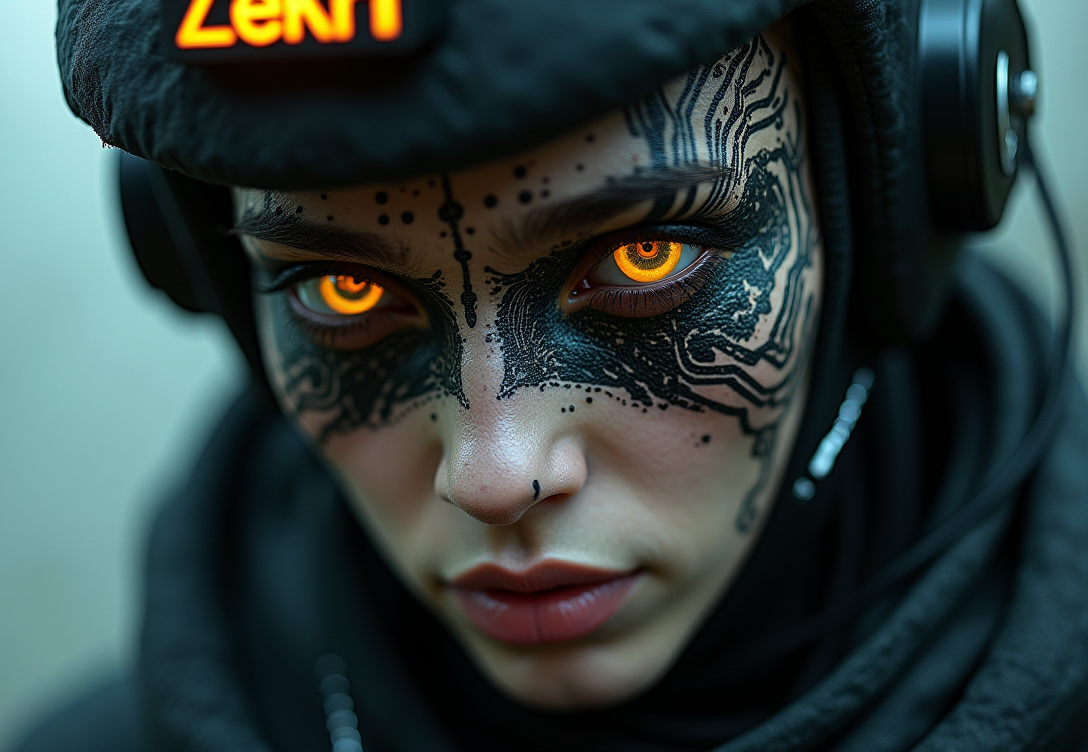

In [7]:
from tqdm import tqdm

image = image_inference(
    positive_prompt="A super close-up realestic portrait of a cyberpunk character, featuring black circuit board tattoos intricately designed on the face, with epic skin details illuminated under harsh lighting. The scene captures a sci-fi darkness inspired by He Xiaofeng, portraying a quiet yet intense fighter, a feudal ninja in a robotic shinobi suit. The portrait is styled after Katy Grannan, with satin textures, glitchy effects, and a foggy atmosphere enhancing the cinematic feel. Integrated into the composition is the word 'Zekri', written in bold yellow letters, seamlessly blending into the futuristic and artistic design. The image exudes high detail and cinematic quality, presented in 8K resolution, with dramatic lighting and a focused composition, creating an artistic masterpiece that captivates the viewer.",
    steps=20,
    width=1080,
    height=756,
    sampler_name="euler",
    scheduler="simple",
    seed=12345,
    save_path="/content/diffusion_kaggle.png"
)
img = Image.open('/content/diffusion_kaggle.png')
display(img)

**8 steps**